In [1]:
#### imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

from numpy.polynomial.hermite import hermgauss

In [3]:
plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 16         
plt.rcParams['axes.titlesize'] = 16     
plt.rcParams['legend.fontsize'] = 14    
plt.rcParams['savefig.dpi'] = 150       
plt.rcParams['axes.labelsize'] = 16   

min_slice = 65000
max_slice = 70000

target_redshift = 2.2
safe_z = str(target_redshift).replace('.', '-')

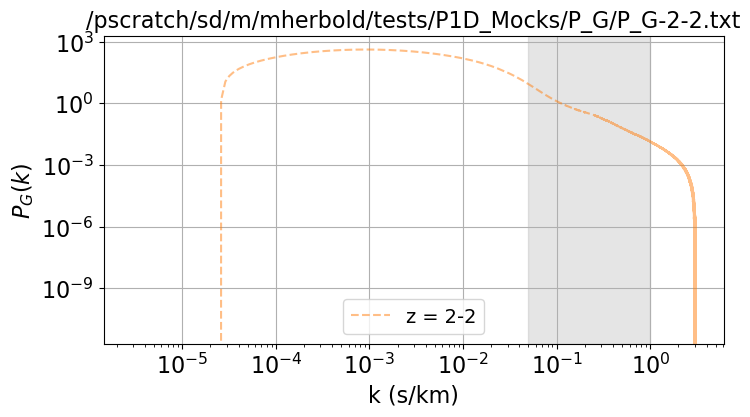

In [4]:
# PG_file_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Backup/P_G-3-0.txt'
# safe_z = '2-8'

PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]

# k_nyquist = np.pi / dv # check Nyquist Frequency
# plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--', alpha=0.5)
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.title(f'{PG_file_path}')
plt.show()

In [5]:
seed = 10       # for repeatability
size = 2**20
dv = 0.911    # km/s
c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

In [6]:
# fitting parameters from mean flux           
tau0   = 673.77e-3
tau1   = 5.31008
nu     = 2.16175
sigma2 = 1.50381


mean (velocity-space):   -0.0010404932425830244
stdev (velocity-space):   1.0005523287554396
shape:  (1048576,)
seed:   10
dv:     0.911


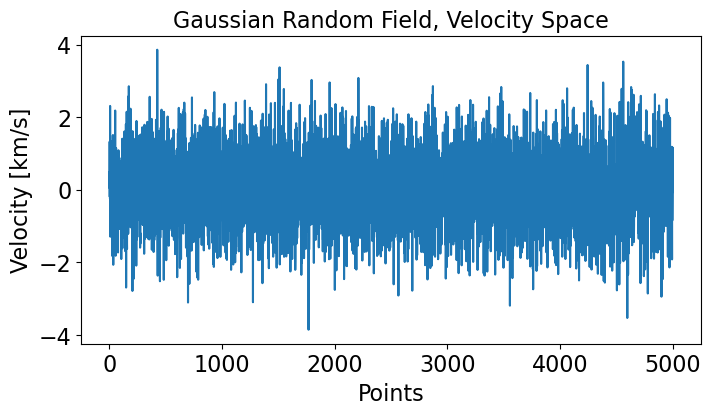

In [7]:
# Generate Gaussian random field in velocity-space
gaussian_random_field = np.random.default_rng(seed).normal(size=size)

# plt.plot(gaussian_random_field)
plt.plot(gaussian_random_field[min_slice:max_slice])
plt.title('Gaussian Random Field, Velocity Space')
plt.xlabel('Points')
plt.ylabel('Velocity [km/s]')

# Check properties
print("mean (velocity-space):  ", gaussian_random_field.mean())
print("stdev (velocity-space):  ", gaussian_random_field.std())
print("shape: ", gaussian_random_field.shape)
print("seed:  ", seed)
print("dv:    ", dv)

gaussian field k-space shape: (524289,)


Text(0, 0.5, 'Amplitude')

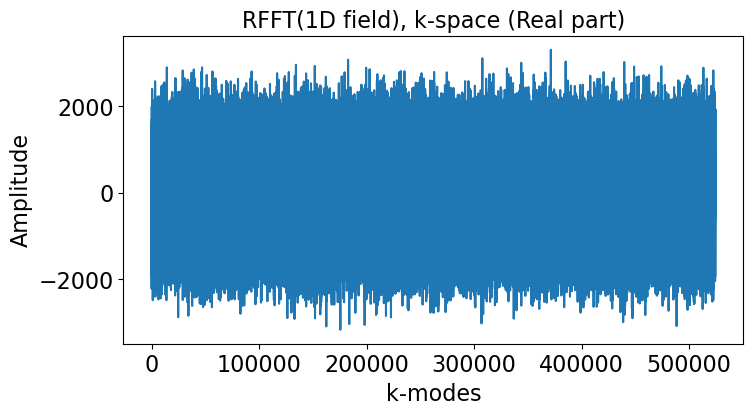

In [8]:
# Compute the FFT to get the field in k-space

gaussian_random_field_k = np.fft.rfft(gaussian_random_field) # normalization ?
print('gaussian field k-space shape: ' + str(gaussian_random_field_k.shape))

# make a grid of k-modes, using same dims as gaussian field
# where d = spacing of the grid
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi

plt.plot(np.real(gaussian_random_field_k)) # plot only real part of fft
plt.title('RFFT(1D field), k-space (Real part)')
plt.xlabel('k-modes')
plt.ylabel('Amplitude')

In [9]:
def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    """
    Transforms a Gaussian white noise field in k-space to a correlated
    Gaussian field in velocity-space, using an imported power spectrum.

    Parameters:
    - file_k_array: array of k values from the power spectrum file [s/km]
    - file_power_array: array of P(k) values [arbitrary units]
    - gaussian_random_field_k: white noise field in rfft space
    - dv: spacing of the velocity grid [km/s]

    Returns:
    - delta_b_tilde: scaled k-space field
    - delta_b: real-space Gaussian field
    - P_k: interpolated and used power spectrum
    """
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # size of real-space grid
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k in units of 1/km

    power_interp = interp1d(file_k_array, file_power_array, 
                            kind='linear', bounds_error=False, 
                            fill_value=0.0)
    
    P_k = power_interp(k)
   
    # Sanitize P_k to ensure it's all finite and non-negative
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse rFFT to real-space Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N)

    return delta_b_tilde, delta_b, P_k


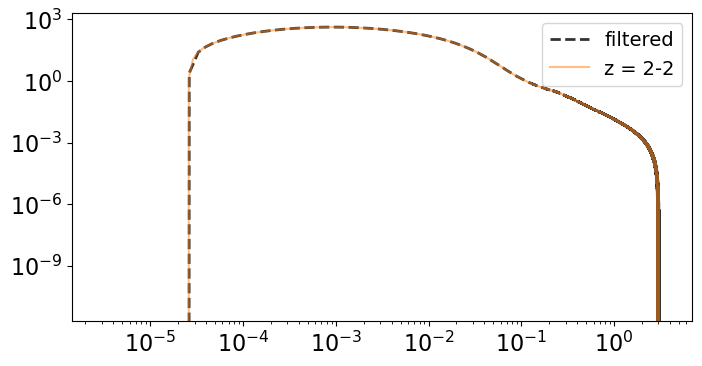

In [10]:
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(k_array, power_array, 
                                         gaussian_random_field_k, dv)

plt.loglog(kmodes[1:], P_k_filtered[1:], label='filtered', ls='--', lw=2, color='black', alpha=0.8)
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange', alpha=0.5)
# plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.legend()

Text(0, 0.5, '$\\tilde\\delta_b(k)$')

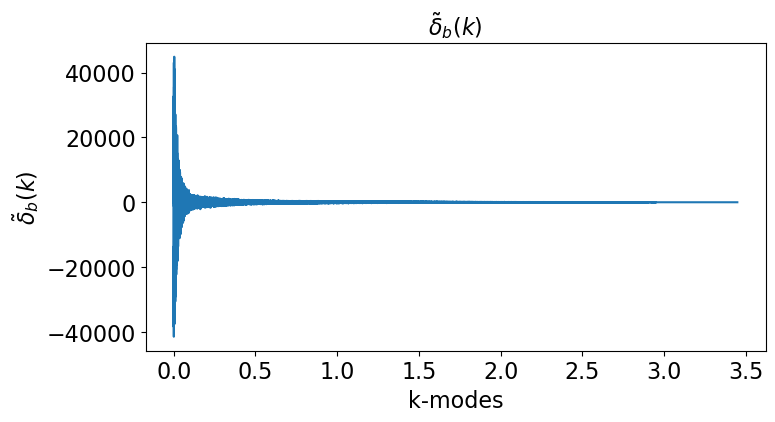

In [11]:
plt.plot(kmodes, np.real(delta_b_tilde))
plt.title(r"$\tilde\delta_b(k)$")
plt.xlabel('k-modes')
plt.ylabel(r"$\tilde\delta_b(k)$")

Variance: 1.50381


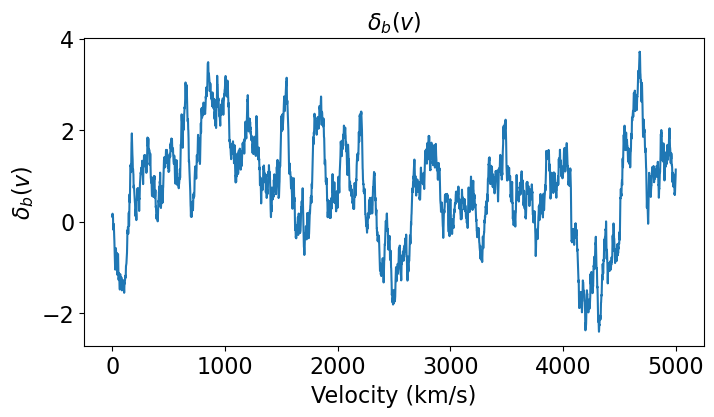

In [12]:
plt.plot(delta_b_v[min_slice:max_slice])
plt.title(r"$\delta_b(v)$")
plt.ylabel(r"$\delta_b(v)$")
plt.xlabel('Velocity (km/s)')

# variance_1d = delta_b_v.var() # sigma^2
variance_1d = sigma2
print(f'Variance: {variance_1d}')

In [13]:
def a2_z(zp, nu=nu, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)

def a_z(zp, nu=nu, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))

In [14]:
delta_b_z = delta_b_v * a_z(zp = target_redshift)
redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)

Text(0.5, 1.0, '$\\delta_b(z)$ (z = 2.2)')

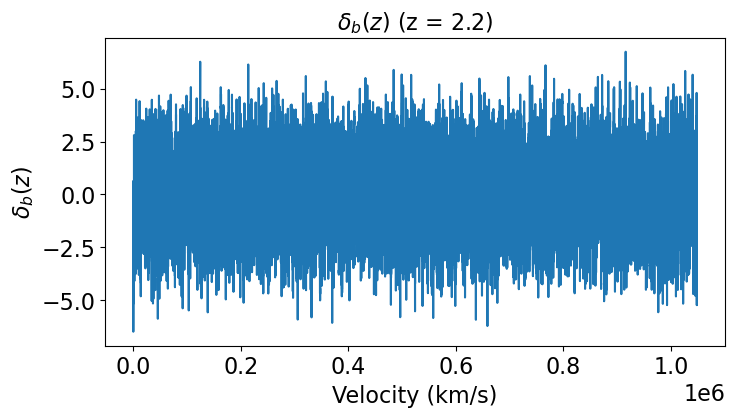

In [15]:
plt.plot(delta_b_z)
plt.ylabel(r'$\delta_b(z)$')
plt.xlabel('Velocity (km/s)')
plt.title(rf'$\delta_b(z)$ (z = {target_redshift})')

Text(0.5, 0, 'Velocity (km/s)')

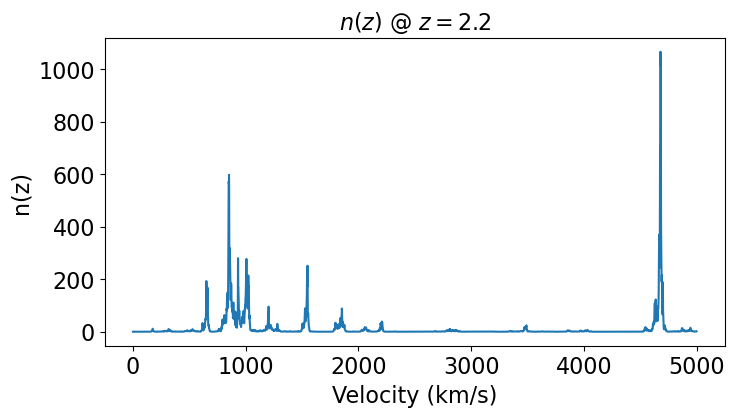

In [16]:
def lognormal_transform(delta_z, sigma2_z):     # note: variance of the field, NOT the oneset by mean flux
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)

# n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
n_z = lognormal_transform(delta_b_z, delta_b_z.var())

plt.plot(n_z[min_slice:max_slice])
plt.title(rf'$n(z)$ @ $z = {target_redshift}$') # , z_0 = 3$')
plt.ylabel('n(z)')
plt.xlabel('Velocity (km/s)')

In [17]:
def t_of_z(zp, tau0=tau0, tau1=tau1, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

def x_of_z(t_z, n_z):
    return t_z * n_z

def f_of_z(x_z):
    return np.exp(-x_z)

In [18]:
t_z = t_of_z(zp=target_redshift) #, tau0=673.77e-3, tau1=5.31008, z0=PD13_PIVOT_Z)
x_z = x_of_z(t_z, n_z)

Text(0.5, 0, 'Velocity (km/s)')

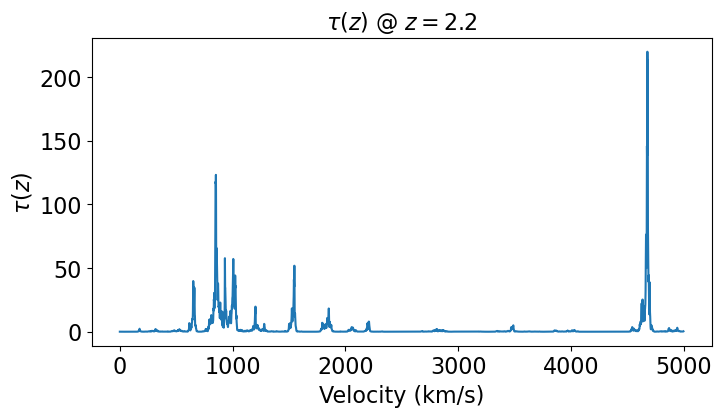

In [19]:
plt.plot(x_z[min_slice:max_slice])
plt.title(rf'$\tau(z)$ @ $z = {target_redshift}$')#, z_0 = 3$')
plt.ylabel(r'$\tau(z)$')
plt.xlabel('Velocity (km/s)')

Text(0.5, 0, 'V [km/s]')

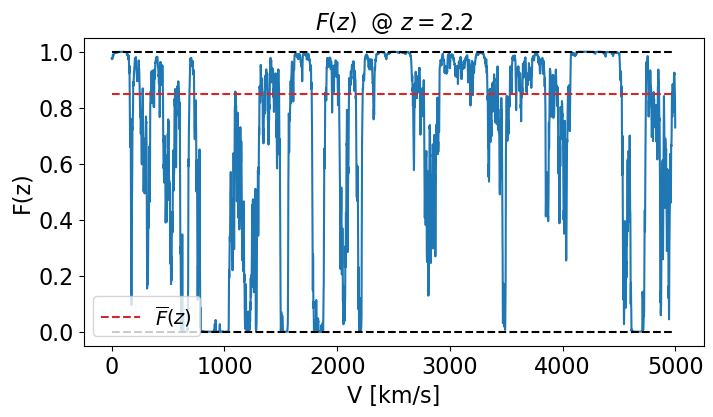

In [20]:
f_z = f_of_z(x_z)

plt.plot(f_z[min_slice:max_slice])
plt.title(rf'$ F(z)$  @ $z = {target_redshift}$') #, z_0 = 3$')
plt.ylabel('F(z)')
plt.hlines(y=0, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=1, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=f_z.mean(), xmin=0,xmax=5000, color='tab:red', ls='--',label=rf'$\overline{{F}}(z)$')
plt.legend(loc = 'lower left')
plt.xlabel('V [km/s]')

In [21]:
# the following are used for the GHQ mean flux calculation

def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)

def x_z(z, sigma2, tau0=tau0, tau1=tau1, nu=nu, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)

def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)

def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

/tmp/ipykernel_2005926/2957027064.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))


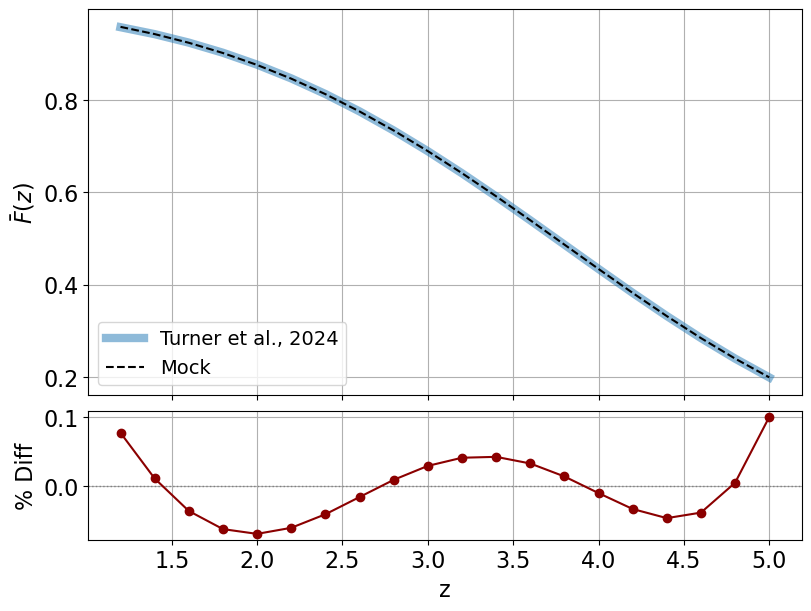

In [22]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])

flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))

# Turner et al. (2024) model
turner_flux = turner24_mf(z_list)

# Calculate percent difference
residuals = 100 * (flux_list - turner_flux) / turner_flux

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

# Top panel: mean flux comparison
ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='Mock', ls='--', color='black')
ax1.set_ylabel(r'$\bar F(z)$')
# ax1.set_title('Mean Flux Comparison')
ax1.legend(loc='lower left')
ax1.grid()

# Bottom panel: percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


In [23]:
def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

def delta_F_k(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    delta_f_tilde = np.fft.rfft(delta_f)
    return(delta_f_tilde)

def P_F(delta_f):
    delta_f_tilde = np.fft.rfft(delta_f)
    P_F = np.abs(delta_f_tilde)**2 / (delta_f.size * dv)
    return(P_F)

In [24]:

test_flux = f_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux)
test_power = P_F(delta_f)

N = len(delta_f)

kmodes2 = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi

window = (kmodes2 > 1e-5) & (kmodes2 < 0.05)  # Window for k_arr


/tmp/ipykernel_2005926/2957027064.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))


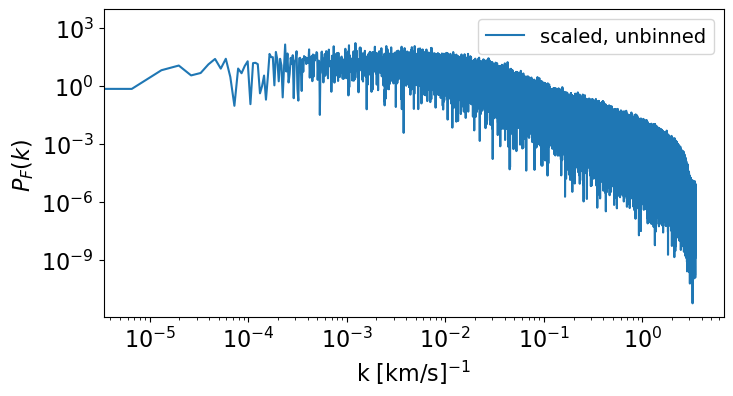

In [25]:
plt.loglog(kmodes2, test_power, label='scaled, unbinned')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel('k [km/s$]^{-1}$')
plt.legend()

statistic shape:  500
bin edges shape:  501
bin number shape: 15202


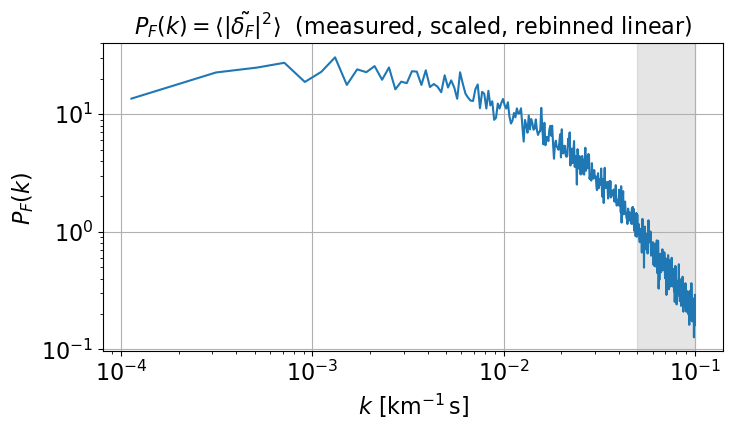

In [26]:
window = (kmodes2 > 1e-5) & (kmodes2 < 0.1)  # Window for k_arr

statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[window], 
                                                                  values = test_power[window], 
                                                                  statistic = 'mean', bins=500)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bin number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                           # in which each value of x belongs. Same length as values 
    
    
bin_centers = 0.5 * (bin_edges_test[1:] + bin_edges_test[:-1])
plt.loglog(bin_centers, statistic_test)

# plt.loglog(bin_edges_test[4:], statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$  (measured, scaled, rebinned linear)')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel(r'$k\ \left[\mathrm{km}^{-1}\,\mathrm{s}\right]$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.grid(True)

In [27]:
def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # window = (kmodes > 1e-5) & (kmodes < 0.05)  # Window for k_arr
    window = (kmodes > 1e-5) & (kmodes < 0.10)  # Window for k_arr
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[window],
                                                       values=power[window],
                                                       statistic='mean', bins=500)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    k_arr = bin_centers
    
    # Remove invalid points
    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    # Initial guess
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    # Now safe to call curve_fit
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)

    print(f'measured_power size: {power.size}')
    print(f'delta_f size: {delta_f.size}')


    return bin_centers, statistic, *popt_mock

In [28]:
DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


In [29]:
test_flux = f_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux)
test_power = P_F(delta_f)
bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, target_redshift)


mock_fit = evaluatePD13Lorentz((bin_centers,target_redshift), *popt_mock_param)

# perr_mock = np.sqrt(np.diag(popt_mock_param))
# mock_upper = evaluatePD13Lorentz((bin_centers,target_redshift), *(popt_mock_param + perr_mock))
# mock_lower = evaluatePD13Lorentz((bin_centers,target_redshift), *(popt_mock_param - perr_mock))

desi_model = evaluatePD13Lorentz((bin_centers,target_redshift), *DESI_EDR_PARAMETERS)

percent_diff = 100 * (mock_fit - desi_model) / desi_model

measured_power size: 524289
delta_f size: 1048576


/tmp/ipykernel_2005926/2957027064.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))
/tmp/ipykernel_2005926/2775189605.py:9: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_2005926/2775189605.py:13: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


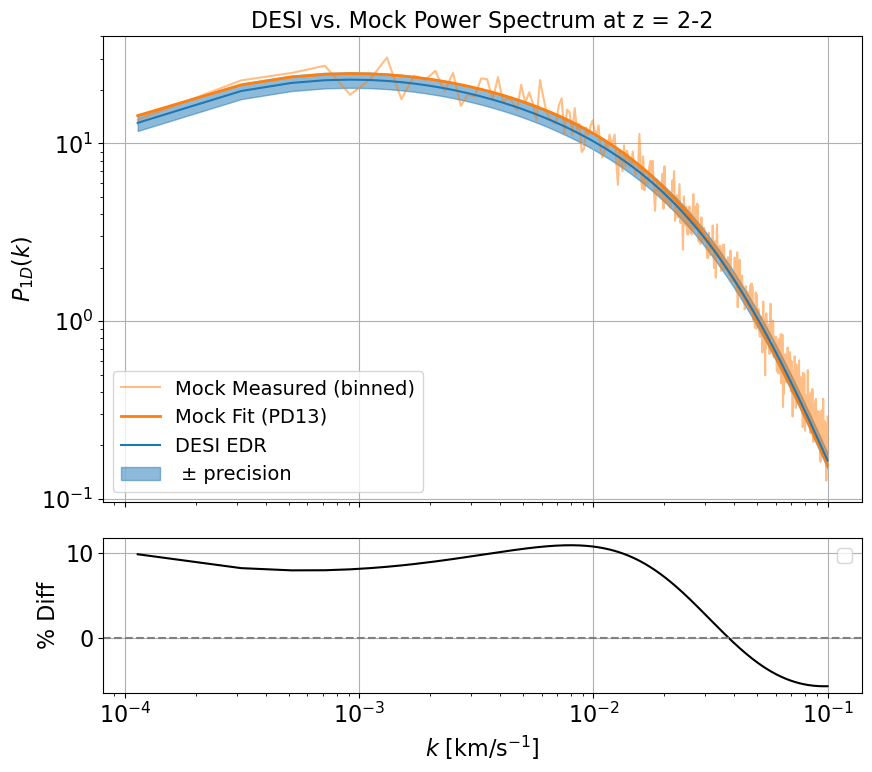

In [30]:

p1d_precision = 1e-1
# w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
w_k = (bin_centers > 1e-5) & (bin_centers < 0.1)  # Window for k_arr
ptrue = desi_model[w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

# Extract data using index mask (w_k)
temp_k = bin_centers[w_k]
temp_p = desi_model[w_k]
temp_e = np.full_like(temp_k, e_p1d)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# Upper plot
ax1.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
    color='tab:blue', label=r'DESI EDR')
ax1.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
                 color='tab:blue', alpha=0.5, label=' ± precision')

ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers, percent_diff, color='black')
ax2.axhline(0, ls='--', color='gray')
ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)

plt.legend()

plt.tight_layout()
plt.show()
